In [ ]:
!pip install shap

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from statsmodels.formula import api
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
import shap

# 데이터 셋 소개

**현재 데이터셋은 미국의 Walmart 중 45개 지점의 판매 데이터입니다.**

각 Column의 내용은 아래와 같습니다.

* Store - 매장 번호
* Date - 판매 주 (일자 범위)
* Weekly_Sales - 해당 매장의 해당 week 매출
* Holiday_Flag - 해당 주에 특별 휴일이 있다면 1/ 없다면 0
* Temperature - 기온 (이 경우는 날씨의 영향으로 인한 방문객 수가 다를 수 있음)
* Fuel_Price - 해당 지역의 연료 가격 (대형 마트의 특성 상 차량 이용율이 높음)
* CPI – 소비자 물가 지수
* Unemployment - 실업률

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Walmart/Walmart.csv')

In [ ]:
original_df = df.copy(deep = True)

In [ ]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


# 프로젝트 진행 이유

* 소비 데이터를 통해 패턴을 분석하여 공휴일, 이벤트 등의 특정 일 자에 대한 분석을 합니다.

* 그에 따라 가중치를 통한 수요 예측을 통해 재고에 대한 부담을 줄이고 더욱 안전한 모델링을 하기 위함입니다.

In [ ]:
# 시점(단위는 한 주를 의미)이라는 특성에 대한 세분화 진행

df.Date = pd.to_datetime(df.Date)

df['weekday'] = df.Date.dt.weekday
df['month'] = df.Date.dt.month
df['year'] = df.Date.dt.year

df.drop(['Date'], axis = 1, inplace = True)

target = 'Weekly_Sales'
features = [i for i in df.columns if i not in [target]]
origin_df = df.copy(deep = True)

df.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,weekday,month,year
0,1,1643690.90,0,42.31,2.572,211.096358,8.106,6,5,2010
1,1,1641957.44,1,38.51,2.548,211.242170,8.106,3,12,2010
2,1,1611968.17,0,39.93,2.514,211.289143,8.106,4,2,2010
3,1,1409727.59,0,46.63,2.561,211.319643,8.106,4,2,2010
4,1,1554806.68,0,46.50,2.625,211.350143,8.106,0,5,2010


In [ ]:
df.shape

(6435, 10)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Weekly_Sales  6435 non-null   float64
 2   Holiday_Flag  6435 non-null   int64  
 3   Temperature   6435 non-null   float64
 4   Fuel_Price    6435 non-null   float64
 5   CPI           6435 non-null   float64
 6   Unemployment  6435 non-null   float64
 7   weekday       6435 non-null   int64  
 8   month         6435 non-null   int64  
 9   year          6435 non-null   int64  
dtypes: float64(5), int64(5)
memory usage: 502.9 KB


In [ ]:
df.nunique().sort_values()

Holiday_Flag       2
year               3
weekday            7
month             12
Store             45
Unemployment     349
Fuel_Price       892
CPI             2145
Temperature     3528
Weekly_Sales    6435
dtype: int64

In [ ]:
nu = df[features].nunique().sort_values()
nf = [] # numerical features
cf = [] # categorical features
nnf = 0
ncf = 0

for i in range(df[features].shape[1]):
  if nu.values[i] <= 45 : cf.append(nu.index[i])
  else: nf.append(nu.index[i])

print('\033[1mInference:\033[0m 데이터셋 내에 {} numerical & {} categorical 특성이 존재함.'.format(len(nf),len(cf)))

Inference: 데이터셋 내에 4 numerical & 5 categorical 특성이 존재함.


In [ ]:
df.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,weekday,month,year
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151,3.573427,6.475524,2010.965035
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885,1.426581,3.321797,0.797019
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000,0.000000,1.000000,2010.000000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000,4.000000,4.000000,2010.000000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000,4.000000,6.000000,2011.000000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000,4.000000,9.000000,2012.000000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000,6.000000,12.000000,2012.000000


# Data Analysis

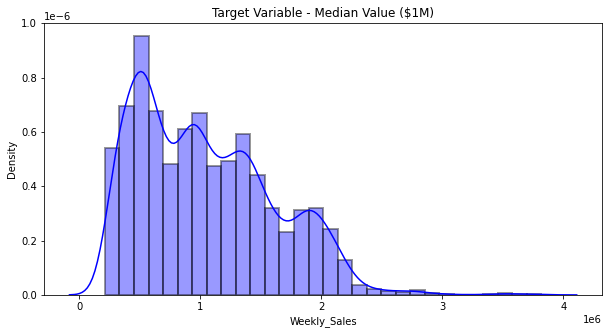

In [ ]:
# 타겟 값의 분포 시각화

plt.figure(figsize = [10, 5])
sns.distplot(df[target], color = 'b', hist_kws = dict(edgecolor = 'black', linewidth = 2), bins = 30)
plt.title('Target Variable - Median Value ($1M)')
plt.show()

타겟값의 분포는 총 20개의 단위 정도로 나뉘는 것으로 보임

                                     범주형 특성 시각화 :                                     


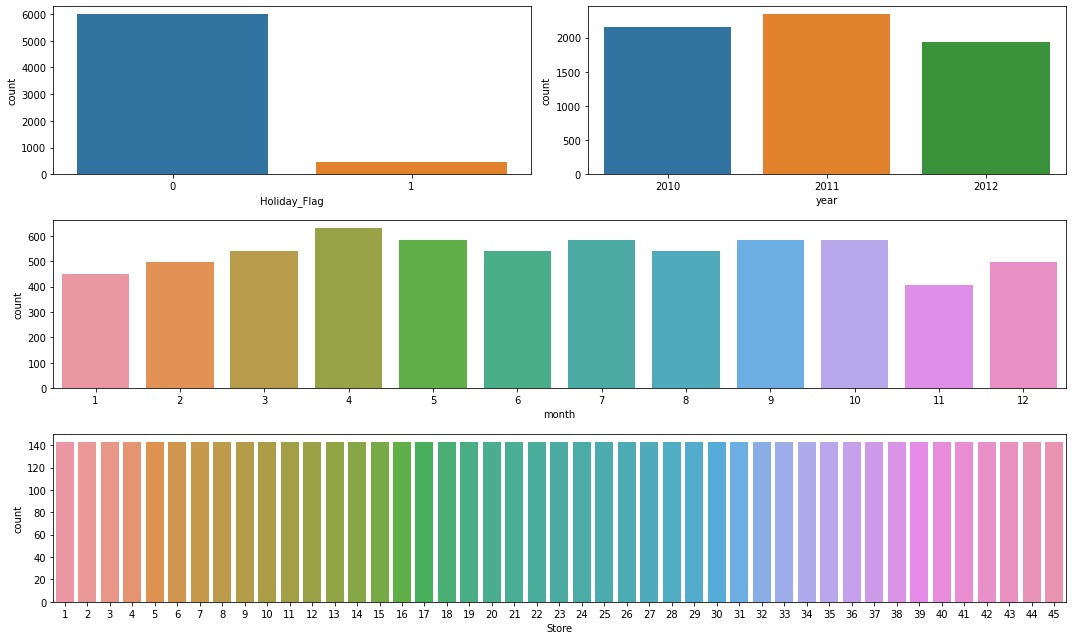

In [ ]:
# 범주형 특성에 대한 시각화

print('\033[1m범주형 특성 시각화 :'.center(90))

n=2
plt.figure(figsize=[15, 3 * math.ceil(len(cf)/n)])

for i in range(len(cf)):
  if df[cf[i]].nunique() <= 8:
    plt.subplot(math.ceil(len(cf) / n), n, i+1)
    sns.countplot(df[cf[i]])
  else:
    plt.subplot(3, 1, i-1)
    sns.countplot(df[cf[i]])
        
plt.tight_layout()
plt.show()

                                      수치형 자료 시각화                                      


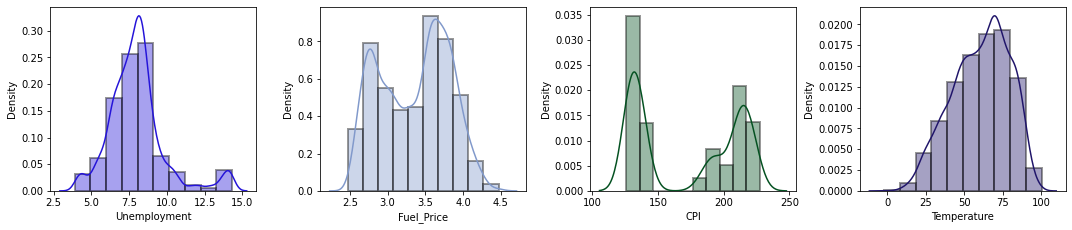

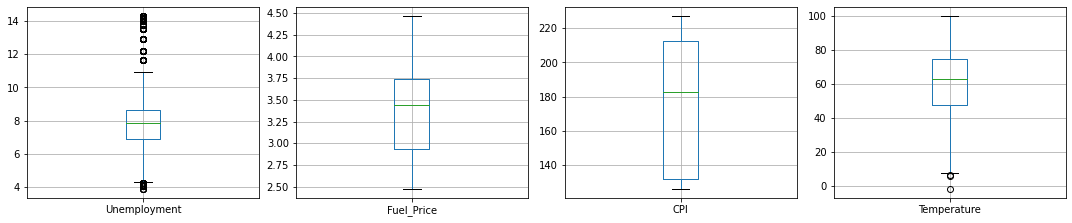

In [ ]:
# 수치형 자료에 대한 시각화

print('\033[1m수치형 자료 시각화'.center(90))

n=4
clr=['r','g','b','g','b','r']

plt.figure(figsize = [15,6 * math.ceil(len(nf) / n)])

for i in range(len(nf)):
  plt.subplot(math.ceil(len(nf) / 3), n, i+1)
  sns.distplot(df[nf[i]],hist_kws = dict(edgecolor = 'black', linewidth = 2), bins = 10, color = list(np.random.randint([255, 255, 255]) /255))
plt.tight_layout()
plt.show()

plt.figure(figsize = [15, 6 * math.ceil(len(nf) / n)])

for i in range(len(nf)):
  plt.subplot(math.ceil(len(nf) / 3), n, i+1)
  df.boxplot(nf[i])
plt.tight_layout()
plt.show()

이상치의 존재 여부가 판단 됨

* 이를 통해 추가적으로 이상치에 대한 처리를 진행

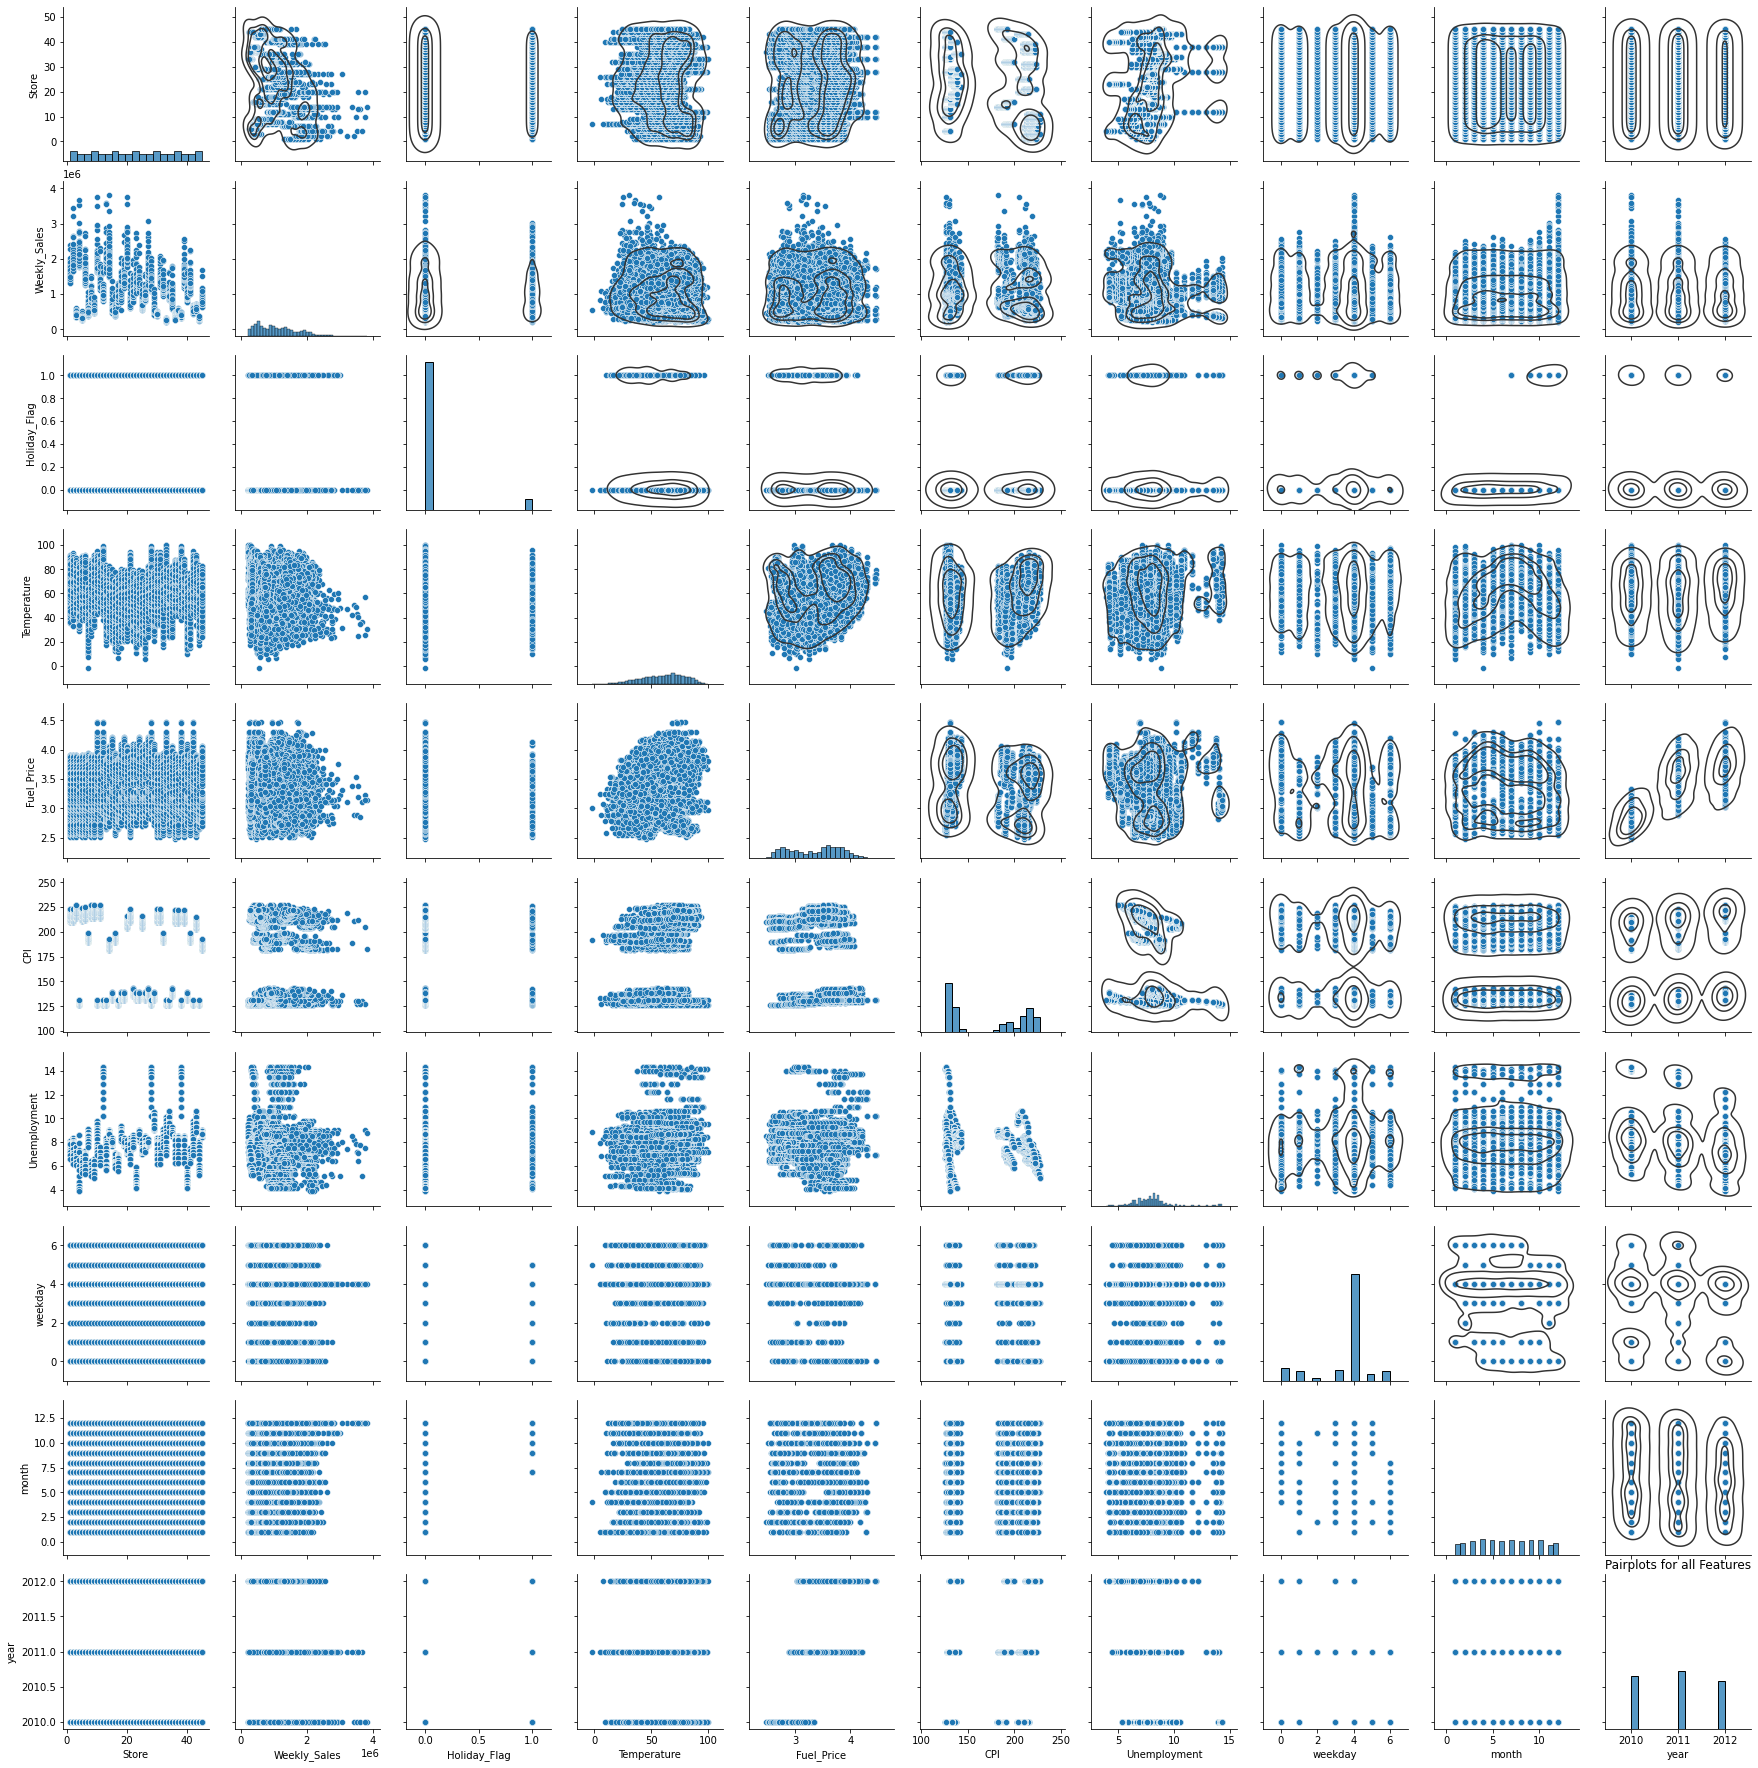

In [ ]:
# 모든 특성 간의 관계 파악을 위한 시각화

g = sns.pairplot(df)
plt.title('Pairplots for all Features')
g.map_upper(sns.kdeplot, levels =4 , color = '.2')
plt.show()

여기서 일부 특성간에 선형관계가 존재한다는 것을 볼 수 있음

# Preprocessing

* 중복값 처리

* 이상치 처리

In [ ]:
# 중복값 확인 및 처리

counter = 0
rs, cs = original_df.shape

df.drop_duplicates(inplace = True)

if df.shape == (rs, cs):
    print('\033[1m결과 :\033[0m 중복값 없음')
else:
    print(f'\033[1m결과 :\033[0m 중복값 제거 및 처리 ---> {rs-df.shape[0]}')

결과 : 중복값 제거 및 처리 ---> 0


In [ ]:
# 결측치 확인

nvc = pd.DataFrame(df.isnull().sum().sort_values(), columns = ['Total Null Values'])
nvc['Percentage'] = round(nvc['Total Null Values'] / df.shape[0], 3) * 100

print(nvc)

              Total Null Values  Percentage
Store                         0         0.0
Weekly_Sales                  0         0.0
Holiday_Flag                  0         0.0
Temperature                   0         0.0
Fuel_Price                    0         0.0
CPI                           0         0.0
Unemployment                  0         0.0
weekday                       0         0.0
month                         0         0.0
year                          0         0.0


결측치는 없음

In [ ]:
# 범주형을 수치형으로 변환

df1 = df.copy()

ecc = nvc[nvc['Percentage'] != 0].index.values
fcc = [i for i in cf if i not in ecc]

oh = True
dm = True

for i in fcc:
  if df1[i].nunique() == 2:
    if oh == True: print("\033[1mOne-Hot 인코딩:\033[0m")
    print(i)
    oh = False
    df1[i] = pd.get_dummies(df1[i], drop_first = True, prefix = str(i)) # 더미형 변수로 binary 하게 변환
  if (df1[i].nunique() > 2):
    if dm == True: print("\033[1m더미 인코딩:\033[0m")
    print(i)
    dm = False
    df1 = pd.concat([df1.drop([i], axis = 1), pd.DataFrame(pd.get_dummies(df1[i], drop_first = True, prefix = str(i)))], axis = 1) 
    # 유니크값이 2개 초과이기 때문에 추가적으로 각 변수 값을 생성해주고 binary 하게 채워줌
        
df1.shape

One-Hot 인코딩:
Holiday_Flag
더미 인코딩:
year
weekday
month
Store


(6435, 69)

In [ ]:
# 이상치 제거

df2 = df1.copy()

features1 = nf

for i in features1:
  q1 = df2[i].quantile(0.25)
  q3 = df2[i].quantile(0.75)
  IQR = q3 - q1
  df2 = df2[df2[i] <= (q3 + (1.5*IQR))]
  df2 = df2[df2[i] >= (q1 - (1.5*IQR))]
  df2 = df2.reset_index(drop = True)
display(df2.head())

print('\033[1m결과 :\033[0m\n이상치 제거 전 데이터셋 샘플 수 : {}.'.format(df1.shape[0]))
print('이상치 제거 후 데이터셋 샘플 수 : {}.'.format(df2.shape[0]))

,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year_2011,year_2012,weekday_1,weekday_2,...,Store_36,Store_37,Store_38,Store_39,Store_40,Store_41,Store_42,Store_43,Store_44,Store_45
0,1643690.90,0,42.31,2.572,211.096358,8.106,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1641957.44,1,38.51,2.548,211.242170,8.106,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1611968.17,0,39.93,2.514,211.289143,8.106,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1409727.59,0,46.63,2.561,211.319643,8.106,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1554806.68,0,46.50,2.625,211.350143,8.106,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


결과 :
이상치 제거 전 데이터셋 샘플 수 : 6435.
이상치 제거 후 데이터셋 샘플 수 : 5953.


IQR (Interquartile range)을 사용한 사분위수의 상위 75% 지점의 값과 하위 25% 지점의 값 차이를 가지고 이상치 처리

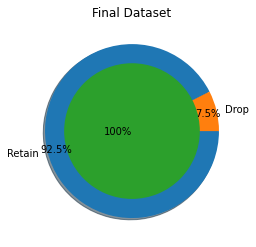

결과 : 전처리 후, 482 샘플 제거, 7.49% 의 데이터 유지.


In [ ]:
# 최종 데이터셋 크기 확인 및 분석

final_df = df2.copy()
final_df.columns = [i.replace('-','_') for i in final_df.columns]

plt.title('Final Dataset')
plt.pie([final_df.shape[0], origin_df.shape[0] - final_df.shape[0]], radius = 1, labels = ['Retain', 'Drop'], counterclock = False, 
        autopct = '%1.1f%%', pctdistance = 0.9, explode = [0, 0], shadow = True)
plt.pie([final_df.shape[0]], labels = ['100%'], labeldistance = -0, radius = 0.78)
plt.show()

print(f'\033[1m결과 :\033[0m 전처리 후, {origin_df.shape[0] - final_df.shape[0]} 샘플 제거, \
{round(100 - (final_df.shape[0] * 100 / (origin_df.shape[0])), 2)}% 의 데이터 유지.')

위와 같은 분석으로 특성간의 상관관계를 알아보았습니다.

* 특성간 상관관계 분석을 통해 관계성이 높은 특성들을 볼 수 있었습니다.

* 수치상 크게 문제가 될 것이라 판단되지는 않습니다.

# 데이터 분할

* 타겟 값은 Weekly_Sales 입니다.

* 데이터셋을 Train / Test로 분할

* Test셋을 다시 Val / Test로 분할

In [ ]:
m=[]
for i in final_df.columns.values:
    m.append(i.replace(' ','_'))
    
final_df.columns = m
X = final_df.drop([target], axis = 1)
y = final_df[target]
X_train, X_test1, y_train, y_test1 = train_test_split(X, y, test_size = 0.2, random_state = 37616652)
X_train.reset_index(drop = True, inplace = True)
X_val, X_test, y_val, y_test = train_test_split(X_test1, y_test1, train_size = 0.66, random_state = 37616652)

print('원본데이터셋 ---> ', X.shape, y.shape, '\n훈련데이터셋 ---> ', X_train.shape, y_train.shape, '\n검증데이터셋 ---> ', X_val.shape, y_val.shape, '\n테스트데이터 ---> ', X_test.shape, y_test.shape)

원본데이터셋 --->  (5953, 68) (5953,) 
훈련데이터셋 --->  (4762, 68) (4762,) 
검증데이터셋 --->  (786, 68) (786,) 
테스트데이터 --->  (405, 68) (405,)


# 데이터 정규화

* Standard Scaler를 통한 정규화로 데이터의 수치 범위 차이가 특성 별, 서로 많은 차이를 보이기 때문에 정규화를 진행합니다.

* 알고자 하는 점은 데이터 내에 있는 여러 특성들을 통해 매출에 대한 예측으로, 온도, 지역내 자원가격, 실업률 등을 포함한 정교한 예측입니다.

In [ ]:
std = StandardScaler()

print('\033[1m훈련셋 스케일링'.center(90))
X_train_std = std.fit_transform(X_train)
X_train_std = pd.DataFrame(X_train_std, columns = X.columns)
display(X_train_std.describe())

print('\033[1m검증셋 스케일링'.center(90))
X_val_std = std.fit_transform(X_val)
X_val_std = pd.DataFrame(X_val_std, columns = X.columns)
display(X_val_std.describe())

print('\033[1m테스트셋 스케일링'.center(80))
X_test_std = std.transform(X_test)
X_test_std = pd.DataFrame(X_test_std, columns = X.columns)
display(X_test_std.describe())

                                       훈련셋 스케일링                                       


,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year_2011,year_2012,weekday_1,weekday_2,weekday_3,...,Store_36,Store_37,Store_38,Store_39,Store_40,Store_41,Store_42,Store_43,Store_44,Store_45
count,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,...,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03
mean,-5.744623e-17,-1.760690e-16,6.043045e-16,-6.266862e-17,2.297849e-16,4.401724e-17,3.133431e-17,-5.893834e-17,1.678624e-17,-3.581064e-17,...,2.088954e-17,-2.088954e-17,-1.492110e-17,3.879486e-17,-1.566715e-17,1.604018e-17,-1.156385e-17,1.678624e-17,2.872312e-17,1.119082e-17
std,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,...,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00
min,-2.733148e-01,-2.978753e+00,-1.897406e+00,-1.270504e+00,-2.753260e+00,-7.529693e-01,-6.557667e-01,-2.611360e-01,-1.167168e-01,-2.759677e-01,...,-1.573123e-01,-1.614682e-01,-5.430110e-02,-1.573123e-01,-1.273520e-01,-1.573123e-01,-1.537717e-01,-1.580118e-01,-1.530547e-01,-1.580118e-01
25%,-2.733148e-01,-7.332905e-01,-9.651418e-01,-1.096568e+00,-6.634295e-01,-7.529693e-01,-6.557667e-01,-2.611360e-01,-1.167168e-01,-2.759677e-01,...,-1.573123e-01,-1.614682e-01,-5.430110e-02,-1.573123e-01,-1.273520e-01,-1.573123e-01,-1.537717e-01,-1.580118e-01,-1.530547e-01,-1.580118e-01
50%,-2.733148e-01,1.122265e-01,1.854511e-01,3.866743e-01,1.027607e-01,-7.529693e-01,-6.557667e-01,-2.611360e-01,-1.167168e-01,-2.759677e-01,...,-1.573123e-01,-1.614682e-01,-5.430110e-02,-1.573123e-01,-1.273520e-01,-1.573123e-01,-1.537717e-01,-1.580118e-01,-1.530547e-01,-1.580118e-01
75%,-2.733148e-01,7.787377e-01,8.289754e-01,9.816619e-01,6.189479e-01,1.328075e+00,1.524932e+00,-2.611360e-01,-1.167168e-01,-2.759677e-01,...,-1.573123e-01,-1.614682e-01,-5.430110e-02,-1.573123e-01,-1.273520e-01,-1.573123e-01,-1.537717e-01,-1.580118e-01,-1.530547e-01,-1.580118e-01
max,3.658785e+00,2.168346e+00,2.460438e+00,1.324376e+00,2.601172e+00,1.328075e+00,1.524932e+00,3.829422e+00,8.567745e+00,3.623612e+00,...,6.356783e+00,6.193171e+00,1.841583e+01,6.356783e+00,7.852254e+00,6.356783e+00,6.503146e+00,6.328643e+00,6.533611e+00,6.328643e+00


                                       검증셋 스케일링                                       


,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year_2011,year_2012,weekday_1,weekday_2,weekday_3,...,Store_36,Store_37,Store_38,Store_39,Store_40,Store_41,Store_42,Store_43,Store_44,Store_45
count,7.860000e+02,7.860000e+02,7.860000e+02,7.860000e+02,7.860000e+02,7.860000e+02,7.860000e+02,7.860000e+02,7.860000e+02,7.860000e+02,...,7.860000e+02,7.860000e+02,786.000000,7.860000e+02,7.860000e+02,7.860000e+02,7.860000e+02,7.860000e+02,7.860000e+02,7.860000e+02
mean,-2.711995e-17,-1.197798e-16,6.644388e-16,6.757388e-16,5.830790e-16,2.711995e-17,-3.502994e-17,1.694997e-17,2.711995e-17,4.519992e-18,...,6.214989e-17,4.067993e-17,0.000000,6.271489e-17,-6.892988e-17,5.310991e-17,-3.728993e-17,2.485996e-17,-9.039984e-18,3.163994e-17
std,1.000637e+00,1.000637e+00,1.000637e+00,1.000637e+00,1.000637e+00,1.000637e+00,1.000637e+00,1.000637e+00,1.000637e+00,1.000637e+00,...,1.000637e+00,1.000637e+00,1.000637,1.000637e+00,1.000637e+00,1.000637e+00,1.000637e+00,1.000637e+00,1.000637e+00,1.000637e+00
min,-2.900654e-01,-2.604320e+00,-1.794233e+00,-1.194599e+00,-2.651733e+00,-7.835579e-01,-6.155870e-01,-2.634156e-01,-1.296827e-01,-2.977292e-01,...,-1.530931e-01,-1.346652e-01,-0.050508,-1.615848e-01,-1.394821e-01,-1.573907e-01,-1.656834e-01,-1.486830e-01,-1.656834e-01,-1.486830e-01
25%,-2.900654e-01,-7.436847e-01,-9.736534e-01,-1.028371e+00,-6.580214e-01,-7.835579e-01,-6.155870e-01,-2.634156e-01,-1.296827e-01,-2.977292e-01,...,-1.530931e-01,-1.346652e-01,-0.050508,-1.615848e-01,-1.394821e-01,-1.573907e-01,-1.656834e-01,-1.486830e-01,-1.656834e-01,-1.486830e-01
50%,-2.900654e-01,1.533909e-01,1.134493e-01,3.292590e-01,1.113196e-01,-7.835579e-01,-6.155870e-01,-2.634156e-01,-1.296827e-01,-2.977292e-01,...,-1.530931e-01,-1.346652e-01,-0.050508,-1.615848e-01,-1.394821e-01,-1.573907e-01,-1.656834e-01,-1.486830e-01,-1.656834e-01,-1.486830e-01
75%,-2.900654e-01,7.843972e-01,8.521926e-01,1.031224e+00,6.300936e-01,1.276230e+00,1.624466e+00,-2.634156e-01,-1.296827e-01,-2.977292e-01,...,-1.530931e-01,-1.346652e-01,-0.050508,-1.615848e-01,-1.394821e-01,-1.573907e-01,-1.656834e-01,-1.486830e-01,-1.656834e-01,-1.486830e-01
max,3.447498e+00,1.942520e+00,2.527636e+00,1.383689e+00,2.564872e+00,1.276230e+00,1.624466e+00,3.796283e+00,7.711131e+00,3.358757e+00,...,6.531973e+00,7.425824e+00,19.798990,6.188699e+00,7.169379e+00,6.353615e+00,6.035609e+00,6.725719e+00,6.035609e+00,6.725719e+00


                                 테스트셋 스케일링                                  


,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year_2011,year_2012,weekday_1,weekday_2,weekday_3,...,Store_36,Store_37,Store_38,Store_39,Store_40,Store_41,Store_42,Store_43,Store_44,Store_45
count,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,...,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000
mean,-0.050123,-0.012162,0.050784,-0.046411,0.072650,0.035271,-0.029302,-0.052913,0.005838,-0.144247,...,0.011970,0.014678,-0.001497,-0.036147,0.022937,-0.012702,0.018059,0.021055,0.033370,0.021055
std,0.917227,0.962034,1.016517,0.994739,1.046261,1.009281,0.985890,0.901262,1.023136,0.734152,...,1.038690,1.053348,0.986329,0.884739,1.078699,0.960945,1.052812,1.068108,1.094407,1.068108
min,-0.290065,-2.661420,-1.794233,-1.194599,-2.741536,-0.783558,-0.615587,-0.263416,-0.129683,-0.297729,...,-0.153093,-0.134665,-0.050508,-0.161585,-0.139482,-0.157391,-0.165683,-0.148683,-0.165683,-0.148683
25%,-0.290065,-0.700992,-0.975865,-1.030859,-0.614323,-0.783558,-0.615587,-0.263416,-0.129683,-0.297729,...,-0.153093,-0.134665,-0.050508,-0.161585,-0.139482,-0.157391,-0.165683,-0.148683,-0.165683,-0.148683
50%,-0.290065,0.058225,0.141097,0.235286,0.212348,-0.783558,-0.615587,-0.263416,-0.129683,-0.297729,...,-0.153093,-0.134665,-0.050508,-0.161585,-0.139482,-0.157391,-0.165683,-0.148683,-0.165683,-0.148683
75%,-0.290065,0.709586,0.875417,0.999684,0.673392,1.276230,1.624466,-0.263416,-0.129683,-0.297729,...,-0.153093,-0.134665,-0.050508,-0.161585,-0.139482,-0.157391,-0.165683,-0.148683,-0.165683,-0.148683
max,3.447498,2.074166,2.485611,1.384955,2.564872,1.276230,1.624466,3.796283,7.711131,3.358757,...,6.531973,7.425824,19.798990,6.188699,7.169379,6.353615,6.035609,6.725719,6.035609,6.725719


# Feature Selection

* 중요한 특성을 선택하기 위함

* Correlation Matrix 분석 진행

* OLS 기법을 통한 Summary 확인

                                  Correlation Matrix                                  


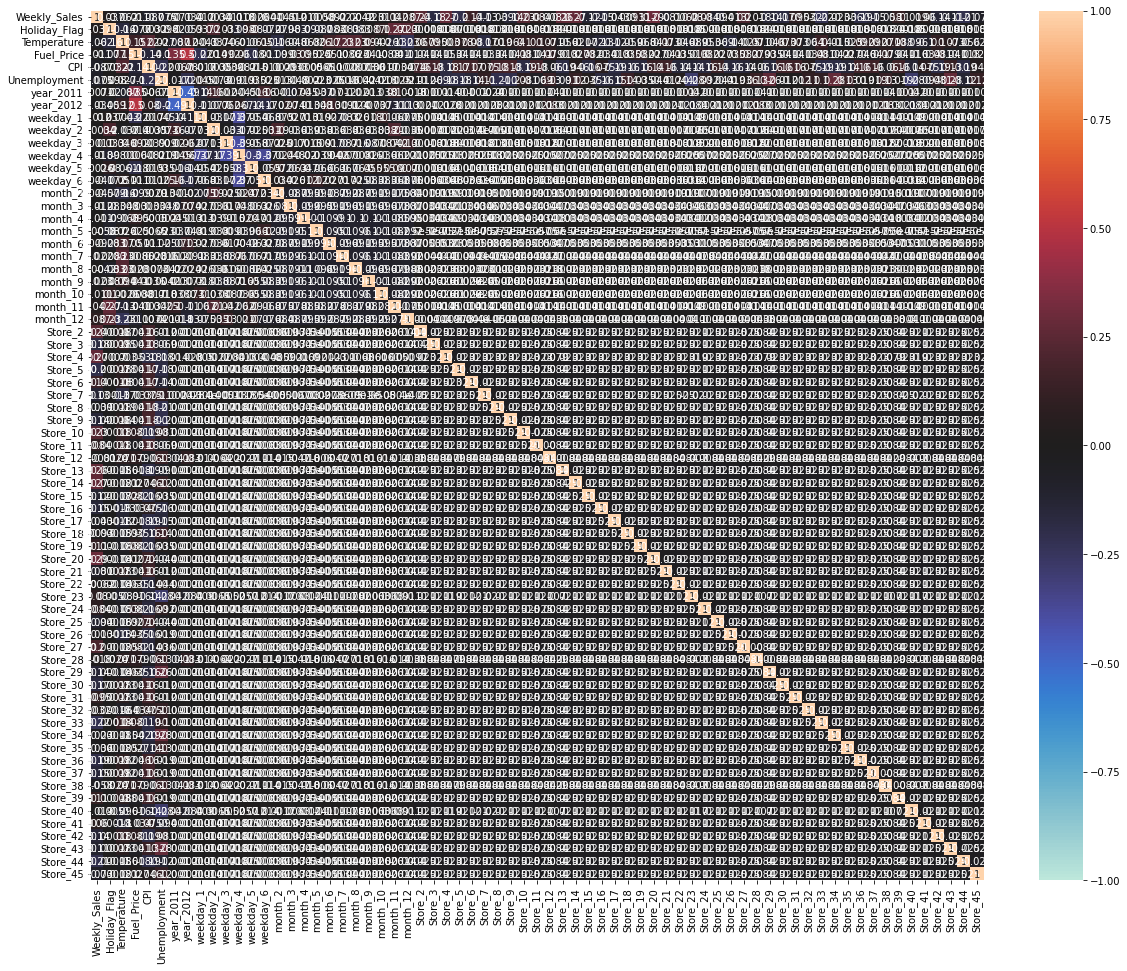

In [ ]:
# Correlation Matrix 시각화를 통한 분석

print('\033[1mCorrelation Matrix'.center(90))
plt.figure(figsize = [20, 16])
sns.heatmap(final_df.corr(), annot = True, vmin =- 1, vmax = 1, center = 0)
plt.show()

In [ ]:
# OLS 기법 확인

train = pd.concat([X_train_std, y_train.reset_index(drop = True)], axis = 1)
a = train.columns.values

API = api.ols(formula = '{} ~ {}'.format(target,' + '.join(i for i in X_train.columns)), data = train).fit()

API.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Weekly_Sales   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     967.1
Date:                Tue, 18 Oct 2022   Prob (F-statistic):               0.00
Time:                        02:37:27   Log-Likelihood:                -63443.
No. Observations:                4762   AIC:                         1.270e+05
Df Residuals:                    4693   BIC:                         1.275e+05
Df Model:                          68                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     1.053e+06   2157.927    487.837      0.000    1.05e+06    1.06e+06
Holiday_Flag  1060.3775   2436.375      0.435      0.663   -3716.062    5836.817
Temperature  -9544.1989   3635.277     -2.625      0.009   -1.67e+04   -2417.349
Fuel_Price    5936.8685   6050.920      0.981      0.327   -5925.776    1.78e+04
CPI           4.586e+05   6.54e+04      7.017      0.000     3.3e+05    5.87e+05
Unemployment -6.589e+04   7226.474     -9.118      0.000   -8.01e+04   -5.17e+04
year_2011    -3.346e+04   6370.447     -5.252      0.000   -4.59e+04    -2.1e+04
year_2012    -7.134e+04   8912.871     -8.004      0.000   -8.88e+04   -5.39e+04
weekday_1     2381.9154   3069.961      0.776      0.438   -3636.650    8400.480
weekday_2    -9837.3055   2564.310     -3.836      0.000   -1.49e+04   -4810.054
weekday_3     -1.28e+04   3068.039     -4.172      0.000   -1.88e+04   -6783.804
weekday_4    -1.593e+04   4100.075     -3.886      0.000    -2.4e+04   -7896.412
weekday_5    -1.085e+04   2813.132     -3.858      0.000   -1.64e+04   -5337.634
weekday_6    -1926.4898   3081.338     -0.625      0.532   -7967.359    4114.380
month_2       2.844e+04   3176.098      8.956      0.000    2.22e+04    3.47e+04
month_3       1.932e+04   3243.649      5.956      0.000     1.3e+04    2.57e+04
month_4       1.899e+04   3456.113      5.496      0.000    1.22e+04    2.58e+04
month_5       1.951e+04   3486.512      5.596      0.000    1.27e+04    2.63e+04
month_6       3.019e+04   3309.653      9.120      0.000    2.37e+04    3.67e+04
month_7       1.529e+04   3474.199      4.401      0.000    8477.625    2.21e+04
month_8       2.328e+04   3375.509      6.897      0.000    1.67e+04    2.99e+04
month_9       1.122e+04   3482.636      3.222      0.001    4393.323     1.8e+04
month_10      1.484e+04   3444.102      4.309      0.000    8087.317    2.16e+04
month_11      3.979e+04   3196.996     12.445      0.000    3.35e+04    4.61e+04
month_12      6.287e+04   3567.799     17.621      0.000    5.59e+04    6.99e+04
Store_2        5.32e+04   2986.106     17.818      0.000    4.74e+04    5.91e+04
Store_3      -1.926e+05   3191.331    -60.359      0.000   -1.99e+05   -1.86e+05
Store_4       2.112e+05   2.12e+04      9.950      0.000     1.7e+05    2.53e+05
Store_5      -2.019e+05   3225.756    -62.575      0.000   -2.08e+05   -1.96e+05
Store_6      -1.105e+04   3177.806     -3.478      0.001   -1.73e+04   -4821.571
Store_7      -1.049e+05   6284.587    -16.695      0.000   -1.17e+05   -9.26e+04
Store_8      -1.173e+05   3370.214    -34.806      0.000   -1.24e+05   -1.11e+05
Store_9      -1.798e+05   3450.588    -52.119      0.000   -1.87e+05   -1.73e+05
Store_10      2.121e+05   2.25e+04      9.446      0.000    1.68e+05    2.56e+05
Store_11      -3.93e+04   3121.244    -12.590      0.000   -4.54e+04   -3.32e+04
Store

# 다중 공선성 문제

* 특성 별 상관 관계가 강할 수록 나타나는 다중 공선성 문제에 대한 해결

* 이 경우 VIF (Variance Inflation Factors) 를 통한 해결을 도모해 본다

* VIF는 분산 팽창 요인으로서, 독립 변수간 상관관계에 대한 측정 척도

제거 특성 -->  ['CPI', 'Unemployment', 'Fuel_Price', 'weekday_4', 'month_7', 'Store_17', 'Temperature', 'year_2012', 'month_12', 'Store_20', 'month_2', 'Store_13', 'Store_3', 'month_5', 'month_11', 'Store_6', 'Store_30', 'Store_9', 'month_10', 'Store_19', 'year_2011', 'Holiday_Flag', 'Store_22', 'month_9', 'Store_45', 'Store_37', 'Store_32', 'Store_18', 'Store_25', 'month_3', 'Store_21', 'Store_16', 'Store_44', 'Store_15', 'Store_43', 'month_4', 'weekday_1', 'Store_23', 'Store_24', 'Store_14', 'Store_26', 'Store_42', 'Store_41', 'weekday_5', 'weekday_2', 'weekday_3', 'Store_27', 'Store_40', 'Store_39', 'Store_11', 'Store_35', 'Store_10', 'month_6', 'Store_2', 'Store_4', 'Store_5']


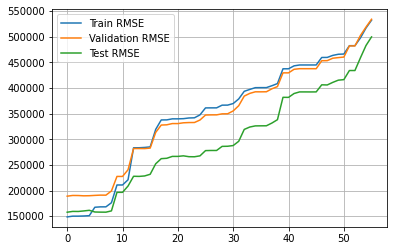

In [ ]:
Trr = []
Tss = []
Ttt = []
n = 3
order = ['ord-' + str(i) for i in range(2, n)]

DROP = []
b = []

for i in range(len(X_train_std.columns)):
  vif = pd.DataFrame()
  X = X_train_std.drop(DROP, axis = 1)
  vif['Features'] = X.columns
  vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
  vif['VIF'] = round(vif['VIF'], 2)
  vif = vif.sort_values(by = 'VIF', ascending = False)
  vif.reset_index(drop = True, inplace = True)
  if vif.loc[0][1] > 1:
    DROP.append(vif.loc[0][0])
    LR = LinearRegression()
    LR.fit(X_train_std.drop(DROP, axis = 1), y_train)

    pred1 = LR.predict(X_train_std.drop(DROP, axis = 1))
    pred2 = LR.predict(X_val_std.drop(DROP, axis = 1))
    pred3 = LR.predict(X_test_std.drop(DROP, axis = 1))
        
    Trr.append(np.sqrt(mean_squared_error(y_train, pred1)))
    Tss.append(np.sqrt(mean_squared_error(y_val, pred2)))
    Ttt.append(np.sqrt(mean_squared_error(y_test, pred3)))
        
print('제거 특성 --> ',DROP)

plt.plot(Trr, label = 'Train RMSE')
plt.plot(Tss, label = 'Validation RMSE')
plt.plot(Ttt, label = 'Test RMSE')
plt.legend()
plt.grid()
plt.show()

In [ ]:
vif_drop_df = X_train_std.drop(DROP, axis = 1)

vif_drop_df

,weekday_6,month_8,Store_7,Store_8,Store_12,Store_28,Store_29,Store_31,Store_33,Store_34,Store_36,Store_38
0,-0.258372,-0.300336,-0.154486,-0.154486,-0.054301,-0.050262,-0.155905,-0.158708,-0.148687,-0.155905,-0.157312,-0.054301
1,-0.258372,-0.300336,-0.154486,-0.154486,-0.054301,-0.050262,-0.155905,-0.158708,-0.148687,-0.155905,-0.157312,-0.054301
2,-0.258372,-0.300336,-0.154486,-0.154486,-0.054301,-0.050262,-0.155905,-0.158708,-0.148687,-0.155905,-0.157312,-0.054301
3,-0.258372,-0.300336,-0.154486,-0.154486,-0.054301,-0.050262,-0.155905,-0.158708,-0.148687,-0.155905,-0.157312,-0.054301
4,-0.258372,-0.300336,-0.154486,-0.154486,-0.054301,-0.050262,-0.155905,-0.158708,-0.148687,-0.155905,-0.157312,-0.054301
...,...,...,...,...,...,...,...,...,...,...,...,...
4757,-0.258372,-0.300336,-0.154486,-0.154486,-0.054301,-0.050262,-0.155905,-0.158708,-0.148687,-0.155905,-0.157312,-0.054301
4758,-0.258372,-0.300336,-0.154486,-0.154486,-0.054301,-0.050262,-0.155905,-0.158708,-0.148687,-0.155905,-0.157312,-0.054301
4759,-0.258372,-0.300336,-0.154486,-0.154486,-0.054301,-0.050262,-0.155905,-0.158708,-0.148687,-0.155905,-0.157312,-0.054301
4760,-0.258372,-0.300336,-0.154486,-0.154486,-0.054301,-0.050262,-0.155905,-0.158708,-0.148687,6.414171,-0.157312,-0.054301


* 위처럼 VIF를 통한 특성 제거를 실행한 결과 데이터 셋 자체가 원래 방향성과는 다른 방향성의 데이터셋이 됨

* 모든 분석 결과를 종합해 추론하자면, 각 특성간의 상관관계는 아주 깊은 연관성을 나타낸다고 볼 수는 없었으며, 위처럼 상관관계에 대하여 VIF 를 통한 다중 공선성 문제 해결을 도모할 경우 오류를 범할 수 있다.

* 결과적으로 머신러닝 모델들을 통한 모델링을 진행할 경우 다중 공선성 문제를 해결해 주기 때문에 따로 특성 제거 없이 진행을 하도록 함

In [ ]:
# RFE를 진행한 데이터셋 생성 및 결과 값(MSE)

lm = LinearRegression()
rfe = RFE(lm, n_features_to_select = X_train_std.shape[1]-28)
rfe = rfe.fit(X_train_std, y_train)

LR = LinearRegression()
LR.fit(X_train_std.loc[:, rfe.support_], y_train)

pred1 = LR.predict(X_train_std.loc[:, rfe.support_])
pred2 = LR.predict(X_val_std.loc[:, rfe.support_])
pred3 = LR.predict(X_test_std.loc[:, rfe.support_])

print(np.sqrt(mean_squared_error(y_train, pred1)))
print(np.sqrt(mean_squared_error(y_val, pred2)))
print(np.sqrt(mean_squared_error(y_test, pred3)))

X_train_rfe = X_train_std.loc[:, rfe.support_]
X_val_rfe = X_val_std.loc[:, rfe.support_]
X_test_rfe = X_test_std.loc[:, rfe.support_]

152709.483190159
182260.98115843462
144474.15411644132


# 모델링 진행

* 모델 평가 함수 구현

* Baseline Model의 경우 Linear Regression 으로 지정

* 가장 직관적이고 간단한 표현 방법은 선이며, 이 선으로의 오차, 손실 값에 대한 분석이기 때문

In [ ]:
Model_Evaluation_Comparison_Matrix = pd.DataFrame(np.zeros([5, 12]), columns = ['Train-R2', 'Val-R2', 'Test-R2', 'Train-RSS', 'Val-RSS', 'Test-RSS',
                                                                            'Train-MSE', 'Val-MSE', 'Test-MSE', 'Train-RMSE', 'Val-RMSE', 'Test-RMSE'])
rc = np.random.choice(X_train_rfe.loc[:, X_train_rfe.nunique() >= 50].columns.values, 2, replace = False)

def Evaluate(n, pred1, pred2, pred3):
  plt.figure(figsize = [15, 6])
  for e,i in enumerate(rc):
    plt.subplot(2, 3, e+1)
    plt.scatter(y = y_train, x = X_train_rfe[i], label = 'Actual')
    plt.scatter(y = pred1, x = X_train_rfe[i], label = 'Prediction')
    plt.legend()
  plt.show()

  print('\n\n{}훈련셋 Metrics{}'.format('-' * 20, '-' * 20))
  print('\n훈련셋 R2-Score  --->',round(r2_score(y_train, pred1), 20))
  print('훈련셋 RSS(잔차 제곱 합)  --->',round(np.sum(np.square(y_train - pred1)), 20))
  print('훈련셋 MSE(평균 제곱 오차)      --->',round(mean_squared_error(y_train, pred1), 20))
  print('훈련셋 RMSE(평균 제곱근 오차) --->',round(np.sqrt(mean_squared_error(y_train, pred1)), 20))

  print('\n\n{}검증셋 Metrics{}'.format('-' * 20, '-' * 20))
  print('\n검증셋 R2-Score  --->',round(r2_score(y_val, pred2), 20))
  print('검증셋 RSS(잔차 제곱 합)  --->',round(np.sum(np.square(y_val - pred2)), 20))
  print('검증셋 MSE(평균 제곱 오차)      --->',round(mean_squared_error(y_val, pred2), 20))
  print('검증셋 RMSE(평균 제곱근 오차) --->',round(np.sqrt(mean_squared_error(y_val, pred2)),20))

  print('\n{}테스트셋 Metrics{}'.format('-' * 20, '-' * 20))
  print('\n테스트셋 R2-Score --->',round(r2_score(y_test, pred3),20))
  print('테스트셋 RSS(잔차 제곱 합)  --->',round(np.sum(np.square(y_test - pred3)), 20))
  print('테스트셋 MSE(평균 제곱 오차)       --->',round(mean_squared_error(y_test, pred3), 20))
  print('테스트셋 RMSE(평균 제곱근 오차) --->',round(np.sqrt(mean_squared_error(y_test, pred3)), 20))
  print('\n{}Residual Plots{}'.format('-'*20, '-'*20))
    
  Model_Evaluation_Comparison_Matrix.loc[n,'Train-R2']  = round(r2_score(y_train, pred1), 20)
  Model_Evaluation_Comparison_Matrix.loc[n,'Val-R2']  = round(r2_score(y_val, pred2), 20)
  Model_Evaluation_Comparison_Matrix.loc[n,'Test-R2']   = round(r2_score(y_test, pred3), 20)
  Model_Evaluation_Comparison_Matrix.loc[n,'Train-RSS'] = round(np.sum(np.square(y_train - pred1)), 20)
  Model_Evaluation_Comparison_Matrix.loc[n,'Val-RSS'] = round(np.sum(np.square(y_val - pred2)), 20)
  Model_Evaluation_Comparison_Matrix.loc[n,'Test-RSS']  = round(np.sum(np.square(y_test - pred3)), 20)
  Model_Evaluation_Comparison_Matrix.loc[n,'Train-MSE'] = round(mean_squared_error(y_train, pred1), 20)
  Model_Evaluation_Comparison_Matrix.loc[n,'Val-MSE'] = round(mean_squared_error(y_val, pred2), 20)
  Model_Evaluation_Comparison_Matrix.loc[n,'Test-MSE']  = round(mean_squared_error(y_test, pred3), 20)
  Model_Evaluation_Comparison_Matrix.loc[n,'Train-RMSE']= round(np.sqrt(mean_squared_error(y_train, pred1)), 20)
  Model_Evaluation_Comparison_Matrix.loc[n,'Val-RMSE']= round(np.sqrt(mean_squared_error(y_val, pred2)), 20)
  Model_Evaluation_Comparison_Matrix.loc[n,'Test-RMSE'] = round(np.sqrt(mean_squared_error(y_test, pred3)), 20)

  plt.figure(figsize = [15, 4])

  plt.subplot(1, 2, 1)
  sns.distplot((y_train - pred1))
  plt.title('Error Terms')          
  plt.xlabel('Errors') 

  plt.subplot(1, 2, 2)
  plt.scatter(y_train, pred1)
  plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
  plt.title('Test vs Prediction')         
  plt.xlabel('y_test')                       
  plt.ylabel('y_pred')                       
  plt.show()

# Baseline Model로 선택한 선형 회귀 모델

<<<----------------------------------- Evaluating Linear Regression Model ----------------------------------->>>



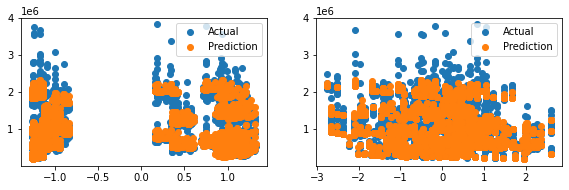



--------------------훈련셋 Metrics--------------------

훈련셋 R2-Score  ---> 0.9289215461985217
훈련셋 RSS(잔차 제곱 합)  ---> 111050726952050.34
훈련셋 MSE(평균 제곱 오차)      ---> 23320186256.20545
훈련셋 RMSE(평균 제곱근 오차) ---> 152709.483190159


--------------------검증셋 Metrics--------------------

검증셋 R2-Score  ---> 0.9005472873048257
검증셋 RSS(잔차 제곱 합)  ---> 26110185288728.516
검증셋 MSE(평균 제곱 오차)      ---> 33219065252.835262
검증셋 RMSE(평균 제곱근 오차) ---> 182260.98115843462

--------------------테스트셋 Metrics--------------------

테스트셋 R2-Score ---> 0.9310030432725177
테스트셋 RSS(잔차 제곱 합)  ---> 8453476389102.8
테스트셋 MSE(평균 제곱 오차)       ---> 20872781207.661236
테스트셋 RMSE(평균 제곱근 오차) ---> 144474.15411644132

--------------------Residual Plots--------------------


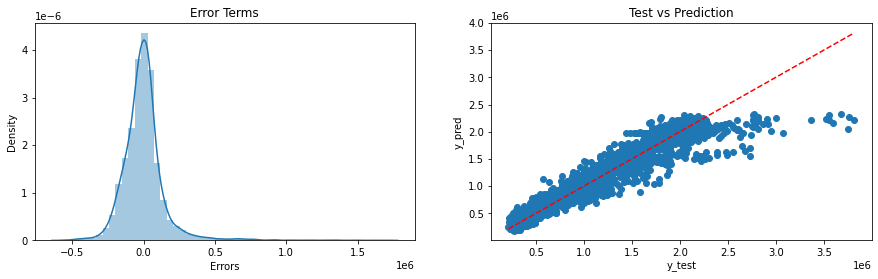

In [ ]:
LR = LinearRegression().fit(X_train_rfe, y_train)
lr_pred1 = LR.predict(X_train_rfe)
lr_pred2 = LR.predict(X_val_rfe)
lr_pred3 = LR.predict(X_test_rfe)

print('{}{}\033[1m Evaluating Linear Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))

Evaluate(0, lr_pred1, lr_pred2, lr_pred3)

# Ridge Regressor

* 이 경우 하이퍼 파라미터에 대한 조절을 실행하고 진행함

In [ ]:
param_distribs1 = {'alpha' : randint(low = 0.00001, high = 1000)}

RLR_rs = RandomizedSearchCV(Ridge(), param_distributions = param_distribs1, cv= 10, n_iter = 300, random_state = 37616652)

In [ ]:
RLR_rs.fit(X_train_rfe, y_train)

RandomizedSearchCV(cv=10, estimator=Ridge(), n_iter=300,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f0ff2622ed0>},
                   random_state=37616652)

In [ ]:
RLR_rs.best_params_

{'alpha': 2}

In [ ]:
RLR = RLR_rs.best_estimator_

<<<----------------------------------- Evaluating Ridge Regression Model ----------------------------------->>>



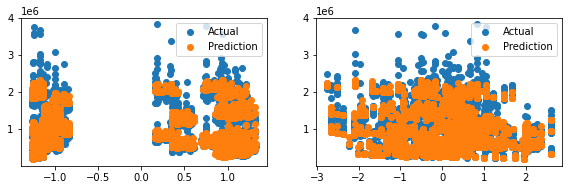



--------------------훈련셋 Metrics--------------------

훈련셋 R2-Score  ---> 0.9289196577071237
훈련셋 RSS(잔차 제곱 합)  ---> 111053677471249.84
훈련셋 MSE(평균 제곱 오차)      ---> 23320805852.84541
훈련셋 RMSE(평균 제곱근 오차) ---> 152711.51185436352


--------------------검증셋 Metrics--------------------

검증셋 R2-Score  ---> 0.9005911989459355
검증셋 RSS(잔차 제곱 합)  ---> 26098656783827.688
검증셋 MSE(평균 제곱 오차)      ---> 33204397943.801125
검증셋 RMSE(평균 제곱근 오차) ---> 182220.73960941198

--------------------테스트셋 Metrics--------------------

테스트셋 R2-Score ---> 0.9310469843100554
테스트셋 RSS(잔차 제곱 합)  ---> 8448092752766.417
테스트셋 MSE(평균 제곱 오차)       ---> 20859488278.4356
테스트셋 RMSE(평균 제곱근 오차) ---> 144428.14226609576

--------------------Residual Plots--------------------


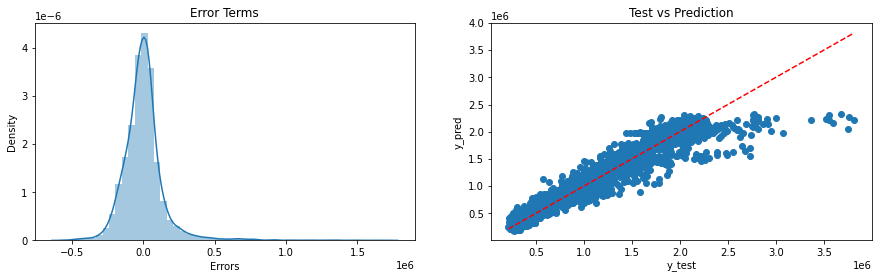

In [ ]:
rlr_pred1 = RLR.predict(X_train_rfe)
rlr_pred2 = RLR.predict(X_val_rfe)
rlr_pred3 = RLR.predict(X_test_rfe)

print('{}{}\033[1m Evaluating Ridge Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))

Evaluate(1, rlr_pred1, rlr_pred2, rlr_pred3)

# Lasso

* 하이퍼 파라미터에 대한 조절을 진행함

In [ ]:
param_distribs2 = {'alpha': randint(low = 0.00001, high = 1000)}

LLR_rs = RandomizedSearchCV(Lasso(), param_distributions = param_distribs2, n_iter = 300, cv = 10, random_state = 37616652)

In [ ]:
LLR_rs.fit(X_train_rfe, y_train)

RandomizedSearchCV(cv=10, estimator=Lasso(), n_iter=300,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f0ff258f190>},
                   random_state=37616652)

In [ ]:
LLR_rs.best_params_

{'alpha': 61}

In [ ]:
LLR = LLR_rs.best_estimator_

<<<----------------------------------- Evaluating Lasso Regression Model ----------------------------------->>>



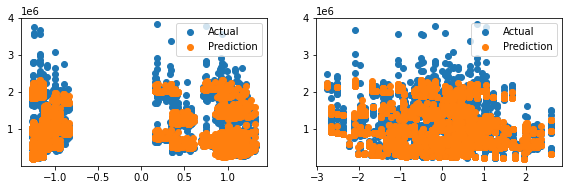



--------------------훈련셋 Metrics--------------------

훈련셋 R2-Score  ---> 0.9289199414913896
훈련셋 RSS(잔차 제곱 합)  ---> 111053234095693.22
훈련셋 MSE(평균 제곱 오차)      ---> 23320712745.84066
훈련셋 RMSE(평균 제곱근 오차) ---> 152711.20700800142


--------------------검증셋 Metrics--------------------

검증셋 R2-Score  ---> 0.9005682504976265
검증셋 RSS(잔차 제곱 합)  ---> 26104681639472.17
검증셋 MSE(평균 제곱 오차)      ---> 33212063154.544746
검증셋 RMSE(평균 제곱근 오차) ---> 182241.7711572864

--------------------테스트셋 Metrics--------------------

테스트셋 R2-Score ---> 0.9310416968622501
테스트셋 RSS(잔차 제곱 합)  ---> 8448740568515.113
테스트셋 MSE(평균 제곱 오차)       ---> 20861087823.494106
테스트셋 RMSE(평균 제곱근 오차) ---> 144433.6796716545

--------------------Residual Plots--------------------


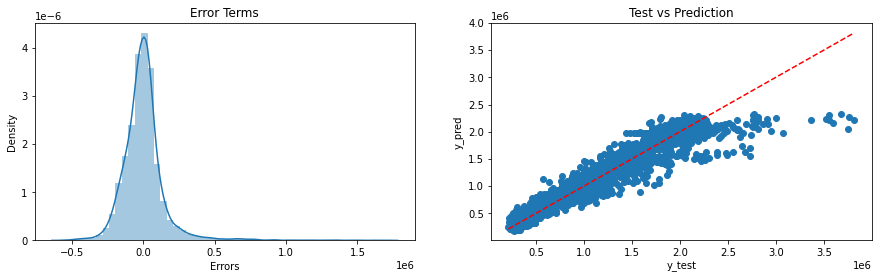

In [ ]:
llr_pred1 = LLR.predict(X_train_rfe)
llr_pred2 = LLR.predict(X_val_rfe)
llr_pred3 = LLR.predict(X_test_rfe)

print('{}{}\033[1m Evaluating Lasso Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))

Evaluate(2, llr_pred1, llr_pred2, llr_pred3)

# ElasticNet

* 하이퍼 파라미터에 대한 조절을 함

In [ ]:
param_distribs3 = {'alpha': randint(low = 0.00001, high = 1000)}

ENR_rs = RandomizedSearchCV(ElasticNet(), param_distributions = param_distribs3, n_iter = 300, cv = 10, random_state = 37616652)

In [ ]:
ENR_rs.fit(X_train_rfe, y_train)

RandomizedSearchCV(cv=10, estimator=ElasticNet(), n_iter=300,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f0ff2156510>},
                   random_state=37616652)

In [ ]:
ENR_rs.best_params_

{'alpha': 2}

In [ ]:
ENR = ENR_rs.best_estimator_

<<<----------------------------------- Evaluating Elastic-Net Regression Model ----------------------------------->>>



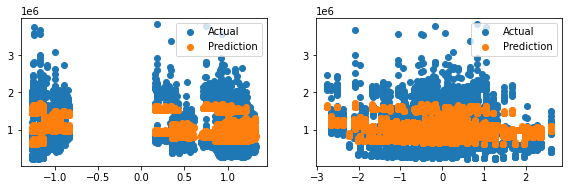



--------------------훈련셋 Metrics--------------------

훈련셋 R2-Score  ---> 0.6238296131048249
훈련셋 RSS(잔차 제곱 합)  ---> 587716708627594.5
훈련셋 MSE(평균 제곱 오차)      ---> 123418040450.98582
훈련셋 RMSE(평균 제곱근 오차) ---> 351309.0383849892


--------------------검증셋 Metrics--------------------

검증셋 R2-Score  ---> 0.6101632584639136
검증셋 RSS(잔차 제곱 합)  ---> 102347228929385.39
검증셋 MSE(평균 제곱 오차)      ---> 130212759452.14427
검증셋 RMSE(평균 제곱근 오차) ---> 360850.0512015264

--------------------테스트셋 Metrics--------------------

테스트셋 R2-Score ---> 0.6208647558850577
테스트셋 RSS(잔차 제곱 합)  ---> 46451481143744.34
테스트셋 MSE(평균 제곱 오차)       ---> 114695015169.73912
테스트셋 RMSE(평균 제곱근 오차) ---> 338666.52502091066

--------------------Residual Plots--------------------


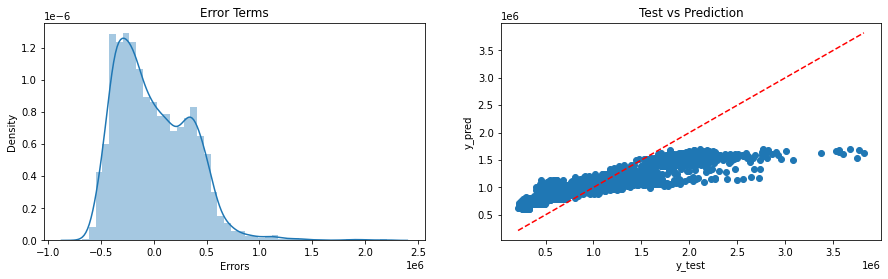

In [ ]:
enr_pred1 = ENR.predict(X_train_rfe)
enr_pred2 = ENR.predict(X_val_rfe)
enr_pred3 = ENR.predict(X_test_rfe)

print('{}{}\033[1m Evaluating Elastic-Net Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))

Evaluate(3, enr_pred1, enr_pred2, enr_pred3)

# RandomForest Regressor

* 마지막 모델로서 역시 파라미터 조절을 진행함

In [ ]:
param_distribs4 = {
    'n_estimators': randint(low = 1, high = 200),
    'max_features': randint(low = 1, high = 10)}

RFR_rs = RandomizedSearchCV(RandomForestRegressor(), param_distributions = param_distribs4, n_iter = 300, cv = 10, random_state = 37616652)

In [ ]:
RFR_rs.fit(X_train_rfe, y_train)

RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(), n_iter=300,
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f0ff202f950>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f0ff2065110>},
                   random_state=37616652)

In [ ]:
RFR_rs.best_params_

{'max_features': 9, 'n_estimators': 121}

In [ ]:
RFR = RFR_rs.best_estimator_

<<<----------------------------------- Evaluating RandomForestRegressor Model ----------------------------------->>>



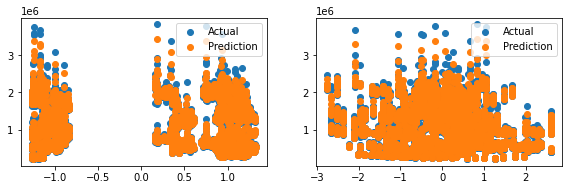



--------------------훈련셋 Metrics--------------------

훈련셋 R2-Score  ---> 0.9892507743831931
훈련셋 RSS(잔차 제곱 합)  ---> 16794249946010.656
훈련셋 MSE(평균 제곱 오차)      ---> 3526721954.223153
훈련셋 RMSE(평균 제곱근 오차) ---> 59386.2101352086


--------------------검증셋 Metrics--------------------

검증셋 R2-Score  ---> 0.8733945888024586
검증셋 RSS(잔차 제곱 합)  ---> 33238819287469.023
검증셋 MSE(평균 제곱 오차)      ---> 42288574157.08527
검증셋 RMSE(평균 제곱근 오차) ---> 205641.85896136335

--------------------테스트셋 Metrics--------------------

테스트셋 R2-Score ---> 0.9132007907336257
테스트셋 RSS(잔차 제곱 합)  ---> 10634600436425.11
테스트셋 MSE(평균 제곱 오차)       ---> 26258272682.53113
테스트셋 RMSE(평균 제곱근 오차) ---> 162044.04550162013

--------------------Residual Plots--------------------


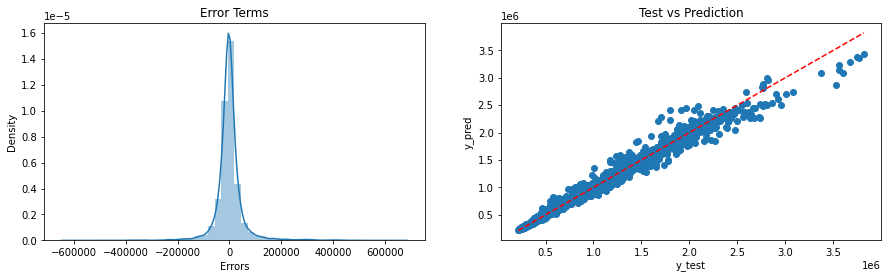

In [ ]:
rfr_pred1 = RFR.predict(X_train_rfe)
rfr_pred2 = RFR.predict(X_val_rfe)
rfr_pred3 = RFR.predict(X_test_rfe)

print('{}{}\033[1m Evaluating RandomForestRegressor Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))

Evaluate(4, rfr_pred1, rfr_pred2, rfr_pred3)

In [ ]:
EMC = Model_Evaluation_Comparison_Matrix.copy()
EMC.index = ['Linear Regression (LR)', 'Ridge Linear Regression (RLR)', 'Lasso Linear Regression (LLR)', 'Elastic-Net Regression (ENR)', 'RandomForestRegressor (RFR)']
EMC

,Train-R2,Val-R2,Test-R2,Train-RSS,Val-RSS,Test-RSS,Train-MSE,Val-MSE,Test-MSE,Train-RMSE,Val-RMSE,Test-RMSE
Linear Regression (LR),0.928922,0.900547,0.931003,1.110507e+14,2.611019e+13,8.453476e+12,2.332019e+10,3.321907e+10,2.087278e+10,152709.483190,182260.981158,144474.154116
Ridge Linear Regression (RLR),0.928920,0.900591,0.931047,1.110537e+14,2.609866e+13,8.448093e+12,2.332081e+10,3.320440e+10,2.085949e+10,152711.511854,182220.739609,144428.142266
Lasso Linear Regression (LLR),0.928920,0.900568,0.931042,1.110532e+14,2.610468e+13,8.448741e+12,2.332071e+10,3.321206e+10,2.086109e+10,152711.207008,182241.771157,144433.679672
Elastic-Net Regression (ENR),0.623830,0.610163,0.620865,5.877167e+14,1.023472e+14,4.645148e+13,1.234180e+11,1.302128e+11,1.146950e+11,351309.038385,360850.051202,338666.525021
RandomForestRegressor (RFR),0.989251,0.873395,0.913201,1.679425e+13,3.323882e+13,1.063460e+13,3.526722e+09,4.228857e+10,2.625827e+10,59386.210135,205641.858961,162044.045502


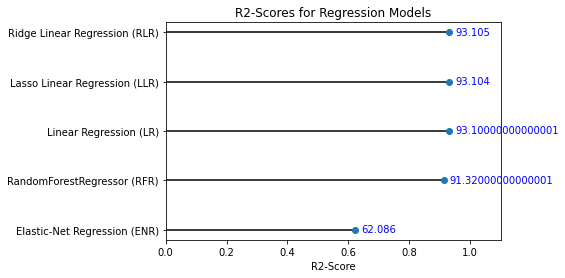

In [ ]:
R2 = round(EMC['Test-R2'].sort_values(ascending = True), 5)
plt.hlines(y = R2.index, xmin = 0, xmax = R2.values)
plt.plot(R2.values, R2.index,'o')
plt.title('R2-Scores for Regression Models')
plt.xlabel('R2-Score')

for i, v in enumerate(R2):
    plt.text(v + 0.02, i - 0.05, str(v * 100), color = 'blue')
plt.xlim([0, 1.1])
plt.show()

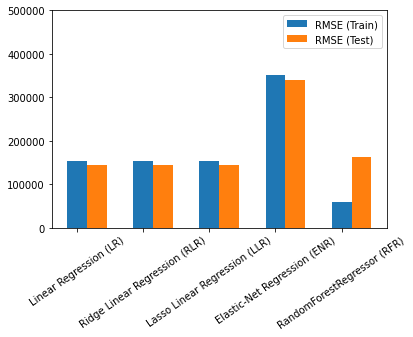

In [ ]:
cc = Model_Evaluation_Comparison_Matrix.columns.values
s = 5

plt.bar(np.arange(5), Model_Evaluation_Comparison_Matrix[cc[9]].values, width = 0.3, label = 'RMSE (Train)')
plt.bar(np.arange(5) + 0.3, Model_Evaluation_Comparison_Matrix[cc[11]].values, width = 0.3, label = 'RMSE (Test)')
plt.xticks(np.arange(5), EMC.index, rotation = 35)
plt.legend()
plt.ylim([0, 500000])
plt.show()

# Feature Importances

* 

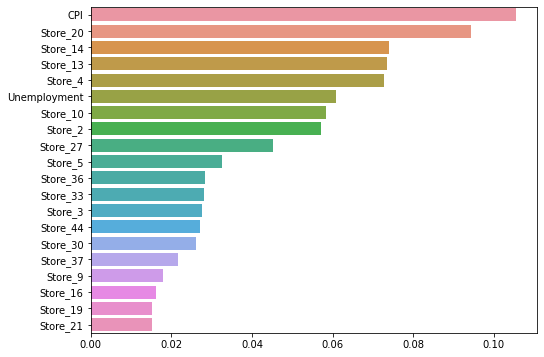

In [ ]:
ftr_importances_values = RFR.feature_importances_

ftr_importances = pd.Series(ftr_importances_values, index = X_train_rfe.columns)
ftr_top = ftr_importances.sort_values(ascending = False)[: 20]
 
plt.figure(figsize = (8, 6))
sns.barplot(x = ftr_top, y = ftr_top.index)
plt.show()

SHAP

In [ ]:
explainer = shap.TreeExplainer(RFR)
shap_values = explainer.shap_values(X_test_rfe)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[1,:], X_test_rfe.iloc[1,:])

* 빨간색으로 나타나는 특성들이 양의 영향도를 나타내며 파란색은 음의 영향도를 나타냄

* 길이가 길게 나타날 수록 영향도의 절대 값 크기가 크게 나타남

# 프로젝트 결과

* 전처리 이후 데이터 셋의 7.5% 가량 삭제 -> 5000여개의 데이터 

* 데이터 분포와 그 관계를 시각화하여 특성간 연관성(선 형)을 알게 됨

* 다중공선성을 보이기 때문에 특성 추출 단계에서 VIF 기법을 사용하여 특성 선택

* Baseline Model 로 기본 파라미터 상태인 선형회귀 모델을 사용

* 추가적으로 사용한 모델은 Ridge(회귀 계수에 제곱의 합을 대입하는 방법), Lasso(회귀 계수에 절대갑의 합을 대입), Elastic-Net (Ridge와 Lasso의 하이브리드 형태), RandomForest Regressor / 이는 모두 파라미터에 대한 조절을 시행

* 성능 평가의 경우 MSE, RMSE, R^2, RSS 에 대한 분석을 진행했으나, 주요하게 비교 분석을 진행한 것은 R^2과 RMSE를 시각화 함

* R^2의 경우에는 값이 클 수록, RMSE의 경우는 값이 작을 수록 예측 값과 실제 값의 차이가 없다고 판단이 가능함 / 그렇기에 이 둘을 중점적으로 비교

* 위처럼 시각화 자료에서 볼 수 있듯, R^2의 경우 Elastic-Net 이외에는 큰 차이를 볼 수 없으며 RMSE 역시 Elastic-Net의 경우 특히 높은 수치를 기록하여 가장 안좋은 성능을 보임. 추가적으로 RMSE 에서 랜덤 포레스트의 경우 Train, Test 셋 둘 간의 차이가 크게 나타나는데, 이는 Split 과정에 있어서 random seed 의 문제로 인한 Split의 오차라고 판단

* 결과적으로 R^2 값에 있어서 다 비슷한 성능을 나타낼 지 모르나, RMSE 값에서 RandomForest Regressor 모델이 가장 낮은 스코어의 Train 기록을 보여줌으로, 이는 성능 면에서 가장 좋은 기대 값을 보일 수 있다고 판단

* 마지막으로 진행 한 특성 중요도 부분에서 CPI(소비자 물가 지수)가 가장 높은 연관성을 나타냄

* 이는 부정적 영향도로 CPI 지수와 음의 선형관계를 보인다고 판단이 됨

* 그 외 특성으로 Store의 경우는 지역 코드이기 때문에 지역별 매출에 대한 차이점을 나타낸 다고 볼 수 있으며, 다음으로 중요한 특성은 Unemployment(실업률)로 나타남